In [1]:
import pandas as pd
import numpy as np

import os
import pickle
import json

import plotly.express as px
import plotly.graph_objects as go

import sys
sys.path.append('../') # this is not necessary if you have 'pyflowmaps/' in the PYTHONPATH 

%load_ext autoreload
%autoreload 2

import pytz
from datetime import datetime, timezone, timedelta

In [2]:
from flowmaps.flowmaps import FlowMaps
from flowmaps.plot import plot_layer
from flowmaps import old_querys as fmq
from flowmaps.geojson import load_geojson


mongodb_params = {
    "host": ['****'],
    "username":'****',
    "password": '****',
    "authSource": '****'
}

mongodb_params = {
    "host": ['127.0.0.1:27017'],
}

fm = FlowMaps(mongodb_params)

tz = pytz.timezone('Europe/Madrid')
cca = '15'

wrong_navarra_cps = ['50683', '20120', '31000', '50500']


output_folder = '../../use-cases/navarra/'

In [73]:
query = fm.layer('codigos_postales')
query.get().plot()

In [66]:
# navarra.geojson
fname = os.path.join(output_folder, 'navarra.geojson')
if os.path.isfile(fname):
    print("Loading:", fname)
    navarra_geojson = load_geojson(fname)
else:
    query = fm.layer('cnig_ccaa', id='15')
    navarra_polygon = query.get_first()    
    navarra_geojson = navarra_polygon.to_geojson()
    navarra_geojson.save(fname)
    
# 15_cp_ids.geojson
fname = os.path.join(output_folder, '15_cp.geojson')
if os.path.isfile(fname):
    print("Loading:", fname)
    nav_cp_geojson = load_geojson(fname)
else:
    navarra_polygon = fm.layer('cnig_ccaa', id='15').get_first()
    query = navarra_polygon.query_overlapping_polygons(target_layer='codigos_postales', use_centroid=True)
    nav_cp_geojson = query.get().to_geojson()
    nav_cp_geojson.save(fname)
    
# cnig_provincias.geojson
fname = os.path.join(output_folder, 'cnig_provincias.geojson')
if os.path.isfile(fname):
    print("Loading:", fname)
    cnig_pro_geojson = load_geojson(fname)
else:
    query = fm.layer('cnig_provincias')
    cnig_pro_geojson = query.get().to_geojson()
    cnig_pro_geojson.save(fname)

Loading: ../../use-cases/navarra/navarra.geojson
Loading: ../../use-cases/navarra/15_cp.geojson
Loading: ../../use-cases/navarra/cnig_provincias.geojson


In [4]:
start_date = datetime(2020, 6, 1, 0, 0, 0, tzinfo=tz)
end_date = datetime(2020, 7, 30, 0, 0, 0, tzinfo=tz)

fname = os.path.join(output_folder, '15.covid_cp.pickle')
if os.path.isfile(fname):
    print("Loading:", fname)
    df_15_covid_cp = pd.read_pickle(fname)
else:
    query = fm.data(start_date, end_date, ev='15.covid_cp')
    df_15_covid_cp = pd.DataFrame(query.get())
    df_15_covid_cp.to_pickle(fname)

df_15_covid_cp['cases'] = df_15_covid_cp.d.apply(lambda x: x['cases'])
data_15_covid_cp = df_15_covid_cp[['id', 'evstart', 'cases']]
data_15_covid_cp = data_15_covid_cp.rename({'evstart': 'date'}, axis=1)

fname = os.path.join(output_folder, 'ES.covid_cpro.pickle')
if os.path.isfile(fname):
    print("Loading:", fname)
    df_es_covid_cpro = pd.read_pickle(fname)
else:
    query = fm.data(start_date, end_date, ev='ES.covid_cpro')
    df_es_covid_cpro = pd.DataFrame(query.get())
    df_es_covid_cpro.to_pickle(fname)

df_es_covid_cpro['cases'] = df_es_covid_cpro.d.apply(lambda x: x['num_casos'])
data_es_covid_cpro = df_es_covid_cpro[['id', 'evstart', 'cases']]
data_es_covid_cpro = data_es_covid_cpro.rename({'evstart': 'date'}, axis=1)

Loading: ../../use-cases/navarra/15.covid_cp.pickle
Loading: ../../use-cases/navarra/ES.covid_cpro.pickle


In [5]:
def plot_cases_navarra(df, ub=100, highlight_threshold=10):
    (lon, lat) = navarra_geojson['features'][0]['centroid']
    fig = px.choropleth_mapbox(data_frame=df,
                                geojson=nav_cp_geojson,
                                locations='loc',
                                color='cases',
                                color_continuous_scale="Reds",
                                range_color=(0, ub),
                                hover_data=['cases'],
                                mapbox_style="carto-positron",
                                opacity=0.8,
                                zoom=8.7,
                                width=900,
                                height=1000,
                                center={"lat":lat, "lon":lon})

    
    cp_cases = { 'type': nav_cp_geojson['type'], 
                 'features': [i for i in nav_cp_geojson['features'] 
                              if df.loc[i['id'], 'cases'] >= highlight_threshold]
               }
    
    layers =[ { 'sourcetype': 'geojson', 'source': navarra_geojson,
                'below': '', 'type': 'line', 
                'color': 'grey', 'opacity': 1 , 
                'line': {'width': 2}
              },
             { 'sourcetype': 'geojson', 'source': cp_cases,
                'below': '', 'type': 'line', 
                'color': 'yellow', 'opacity': 1 , 
                'line': {'width': 2}
              }
            ]
    fig.layout.update(mapbox_layers=layers)
   
    return fig

max_cases = 0
time_windows = 7
for i in range(1,16):
    s = datetime(2020, 7, i, 0, 0, 0, tzinfo=tz)
    e = s + timedelta(days=time_windows)
    mask = (data_15_covid_cp.date >= s) & (data_15_covid_cp.date <= e)
    df = data_15_covid_cp[mask].groupby(['id']).cases.sum()
    x = df.max()
    if max_cases < x:
        max_cases = x

for i in range(1, (31 - time_windows) + 1):
    s = datetime(2020, 7, i, 0, 0, 0, tzinfo=tz)
    e = s + timedelta(days=time_windows)
    mask = (data_15_covid_cp.date >= s) & (data_15_covid_cp.date <= e)
    data_dict = {i:0 for i in all_cps_navarra}
    data_dict.update(data_15_covid_cp[mask].groupby(['id']).cases.sum())
    df = pd.DataFrame(pd.Series(data_dict), columns=['cases'])
    df['loc'] = df.index

    fig = plot_cases_navarra(df, ub=max_cases)
    
    title = "Navarra cases  from %s to %s" % (s.strftime("%d/%m"), e.strftime("%d/%m") )
    fig.update_layout({'title': title})
    fig.update_layout(margin={"r":0,"t":25,"l":0,"b":0})
    
    fig_fname = "Navarra_cases_%s-%s.png" % (s.strftime("%d.%m"), e.strftime("%d.%m") )
    fig_fname = os.path.join(output_folder, fig_fname)
    fig.write_image(fig_fname)
    
    print("Saving %s" % fig_fname)

Saving ../../use-cases/navarra/Navarra_cases_01.07-08.07.png
Saving ../../use-cases/navarra/Navarra_cases_02.07-09.07.png
Saving ../../use-cases/navarra/Navarra_cases_03.07-10.07.png
Saving ../../use-cases/navarra/Navarra_cases_04.07-11.07.png
Saving ../../use-cases/navarra/Navarra_cases_05.07-12.07.png
Saving ../../use-cases/navarra/Navarra_cases_06.07-13.07.png
Saving ../../use-cases/navarra/Navarra_cases_07.07-14.07.png
Saving ../../use-cases/navarra/Navarra_cases_08.07-15.07.png
Saving ../../use-cases/navarra/Navarra_cases_09.07-16.07.png
Saving ../../use-cases/navarra/Navarra_cases_10.07-17.07.png
Saving ../../use-cases/navarra/Navarra_cases_11.07-18.07.png
Saving ../../use-cases/navarra/Navarra_cases_12.07-19.07.png
Saving ../../use-cases/navarra/Navarra_cases_13.07-20.07.png
Saving ../../use-cases/navarra/Navarra_cases_14.07-21.07.png
Saving ../../use-cases/navarra/Navarra_cases_15.07-22.07.png
Saving ../../use-cases/navarra/Navarra_cases_16.07-23.07.png
Saving ../../use-cases/n

In [71]:
navarra_geojson['features'][0]["centroid"]

[-1.6461594504360129, 42.66717341880263]

In [28]:
d_day = 6
highlight_threshold = 10

s = datetime(2020, 7, d_day, 0, 0, 0, tzinfo=tz)
e = s + timedelta(days=time_windows)

mask = (data_15_covid_cp.date >= s) & (data_15_covid_cp.date <= e)
data_dict = {i:0 for i in all_cps_navarra}
data_dict.update(data_15_covid_cp[mask].groupby(['id']).cases.sum())
df = pd.DataFrame(pd.Series(data_dict), columns=['cases'])
df['loc'] = df.index


hotspots = ['31014', '31008']
# hotspots = { 'type': nav_cp_geojson['type'], 
#              'features': [f for f in nav_cp_geojson['features'] 
#                           if f['id'] in ['31014', '31008']]
#            }


query = fm.query(collection_name='layers.overlaps')
query.filter({'l.layer': 'mitma_mov', 'm.layer': 'codigos_postales'})
query.filter({'m.id': {'$in': hotspots}})
query.filter({'m.ratio': {'$gt': 0.25}})
cp2mitma = {d['m']['id']: d['l']['id'] for d in  list(query.get())}

cp2mitma


{'31008': '3120103', '31014': '3120107'}

In [51]:
e = datetime(2020, 7, d_day, 0, 0, 0, tzinfo=tz)
s = e - timedelta(days=10)

query = fm.mobility('mitma_mov.daily_mobility_matrix', s, e)
query.filter({'destino': {'$in': mitma_mov_areas_ids}})
cursor = query.get()
df_mov = cursor.to_df()

query = fm.query(collection_name='layers.overlaps')
query.filter({'l.layer': 'cnig_provincias', 'm.layer': 'mitma_mov'})
query.filter({'m.ratio': {'$gt': 0.5}})
mitma2prov = {d['m']['id']:d['l']['id'] for d in list(query.get())}

df_mov['prov_origen'] = df_mov.origen.apply(lambda x: mitma2prov[x])
df_mov['prov_destino'] = df_mov.destino.apply(lambda x: mitma2prov[x])

df_15_mov = df_mov[['prov_origen', 'prov_destino', 'origen', 'destino', 'viajes']]

In [52]:
df_15_mov_incomming = df_15_mov.groupby(['prov_origen', 'destino']).viajes.sum().reset_index()
df_15_mov_incomming = df_15_mov[df_15_mov.prov_origen != '31']
df_15_mov_incomming = df_15_mov_incomming.sort_values(by=['destino', 'viajes'], ascending=[True,False])

df_15_mov_internal = df_15_mov[df_15_mov.prov_origen == '31']
df_15_mov_internal = df_15_mov_internal[['origen', 'destino', 'viajes']]
df_15_mov_internal = df_15_mov_internal.sort_values(by=['viajes'], ascending=[False])
mask = df_15_mov_internal.origen != df_15_mov_internal.destino

In [61]:
# df_15_mov_incomming
e = datetime(2020, 7, 4, 0, 0, 0, tzinfo=tz)
s = e - timedelta(days=7)
print(s)
print(e)
mask = ( data_es_covid_cpro.date >= s ) & (data_es_covid_cpro.date < e )
cum_cases_pro = data_es_covid_cpro[mask].groupby(['id']).cases.sum().to_dict()

codprov2name = {i['id']:i["properties"]['rotulo'] for i in cnig_pro_geojson["features"]}


df_15_mov_incomming['cases_prov_origen'] = df_15_mov_incomming.prov_origen.apply(lambda x: aux[x])

mask = df_15_mov_incomming.destino=='3120107'

df_aux = df_15_mov_incomming[mask]
df_aux = df_aux.groupby(['prov_origen', 'destino']).sum().reset_index()

df_aux['cases_prov_origen'] = df_aux.prov_origen.apply(lambda x: cum_cases_pro[x])
df_aux['provincia'] = df_aux.prov_origen.apply(lambda x: codprov2name[x])

df_aux = df_aux.sort_values(by=['viajes', 'cases_prov_origen'], ascending=[False, False])
df_aux = df_aux[['provincia', 'cases_prov_origen', 'viajes']]
df_aux[df_aux.cases_prov_origen > 100]

2020-06-29 00:00:00-00:15
2020-07-06 00:00:00-00:15


provincia  cases_prov_origen    viajes
44   Zaragoza                110  1629.862
25     Madrid                300   812.507
19     Huesca                112   804.337
7   Barcelona                844   282.626
22     Lleida                822    85.909
24       Lugo                119     8.082

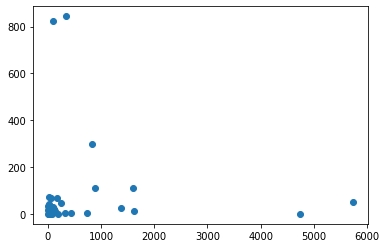

In [58]:
import matplotlib.pyplot as plt

plt.scatter(df_aux.viajes, df_aux.cases_prov_origen)